
# Adaptive Primal-Dual
This tutorial compares the traditional Chambolle-Pock Primal-dual algorithm
with the Adaptive Primal-Dual Hybrid Gradient of Goldstein and co-authors.

By adaptively changing the step size in the primal and the dual directions,
this algorithm shows faster convergence, which is of great importance for some
of the problems that the Primal-Dual algorithm can solve - especially those
with an expensive proximal operator.

For this example, we consider a simple denoising problem.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylops
from skimage.data import camera

import pyproximal

plt.close('all')

def callback(x, f, g, K, cost, xtrue, err):
    cost.append(f(x) + g(K.matvec(x)))
    err.append(np.linalg.norm(x - xtrue))

# cost means cost function and err means error function
# .append: add an item to a list
# .matvec: matrix-vector multiplication
# np.linalg.norm: calculate the norm of an array

Let's start by loading a sample image and adding some noise



In [2]:
# Load image
img = camera()
ny, nx = img.shape

# Add noise
sigman = 20
n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

We can now define a :class:`pylops.Gradient` operator as well as the
different proximal operators to be passed to our solvers



In [3]:
# Gradient operator
sampling = 1.
Gop = pylops.Gradient(dims=(ny, nx), sampling=sampling, edge=False,
                      kind='forward', dtype='float64')
L = 8. / sampling ** 2 # maxeig(Gop^H Gop)

# L2 data term
lamda = .04
l2 = pyproximal.L2(b=noise_img.ravel(), sigma=lamda)

# L1 regularization (isotropic TV)
l1iso = pyproximal.L21(ndim=2)

To start, we solve our denoising problem with the original Primal-Dual
algorithm



In [4]:
# Primal-dual
tau = 0.95 / np.sqrt(L)
mu = 0.95 / np.sqrt(L)

cost_fixed = []
err_fixed = []
iml12_fixed = \
    pyproximal.optimization.primaldual.PrimalDual(l2, l1iso, Gop,
                                                  tau=tau, mu=mu, theta=1.,
                                                  x0=np.zeros_like(img.ravel()),
                                                  gfirst=False, niter=300, show=True,
                                                  callback=lambda x: callback(x, l2, l1iso,
                                                                              Gop, cost_fixed,
                                                                              img.ravel(),
                                                                              err_fixed))
iml12_fixed = iml12_fixed.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau = 0.33587572106361		mu = 0.33587572106361
theta = 1.00		niter = 300

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   2.41061e+00   1.147e+08   1.329e+05   0.000e+00       1.149e+08
     2   4.85086e+00   1.118e+08   1.387e+05   0.000e+00       1.119e+08
     3   7.30787e+00   1.089e+08   1.220e+05   0.000e+00       1.090e+08
     4   9.77320e+00   1.061e+08   1.117e+05   0.000e+00       1.062e+08
     5   1.22456e+01   1.034e+08   1.109e+05   0.000e+00       1.035e+08
     6   1.47089e+01   1.008e+08   1.143e+05   0.000e+00       1.009e+08
     7   1.71778e+01   9.818e+07   1.187e+05   0.000e+00       9.829e+07
     8   1.96439e+01   

We do the same with the adaptive algorithm



In [5]:
cost_ada = []
err_ada = []
iml12_ada, steps = \
    pyproximal.optimization.primaldual.AdaptivePrimalDual(l2, l1iso, Gop,
                                                          tau=tau, mu=mu,
                                                          x0=np.zeros_like(img.ravel()),
                                                          niter=45, show=True, tol=0.05,
                                                          callback=lambda x: callback(x, l2, l1iso,
                                                                                      Gop, cost_ada,
                                                                                      img.ravel(),
                                                                                      err_ada))
iml12_ada = iml12_ada.reshape(img.shape)

Adaptive Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau0 = 3.358757e-01	mu0 = 3.358757e-01
alpha0 = 5.000000e-01	eta = 9.500000e-01
s = 1.000000e+00	delta = 1.500000e+00
niter = 45		tol = 5.000000e-02

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     2   2.41061e+00   1.147e+08   1.329e+05   0.000e+00       1.149e+08
     3   7.22725e+00   1.089e+08   1.630e+05   0.000e+00       1.091e+08
     4   1.60780e+01   9.882e+07   2.034e+05   0.000e+00       9.902e+07
     5   3.09835e+01   8.310e+07   2.861e+05   0.000e+00       8.339e+07
     6   5.36588e+01   6.208e+07   4.075e+05   0.000e+00       6.249e+07
     7   8.39987e+01   3.913e+07   5.556e+05   0.000e+00       3.968e+07
     8   1

Let's now compare the final results as well as the convergence curves of the
two algorithms. We can see how the adaptive Primal-Dual produces a better
estimate of the clean image in a much smaller number of iterations



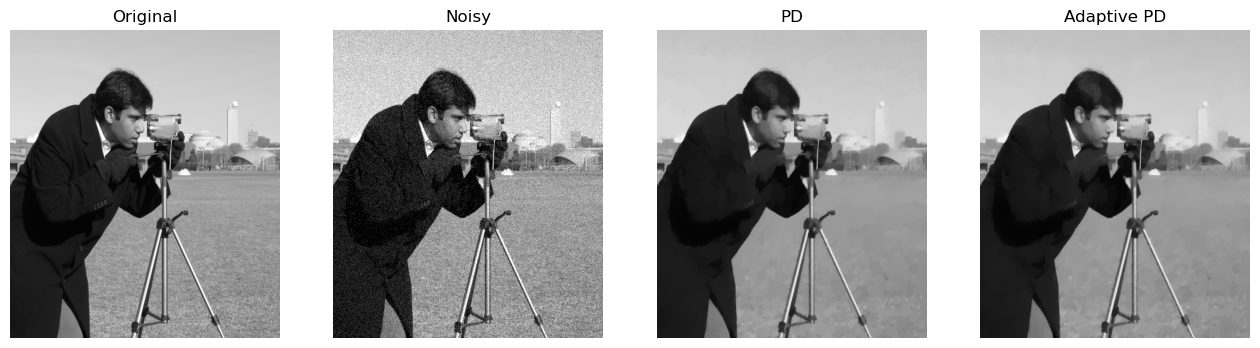

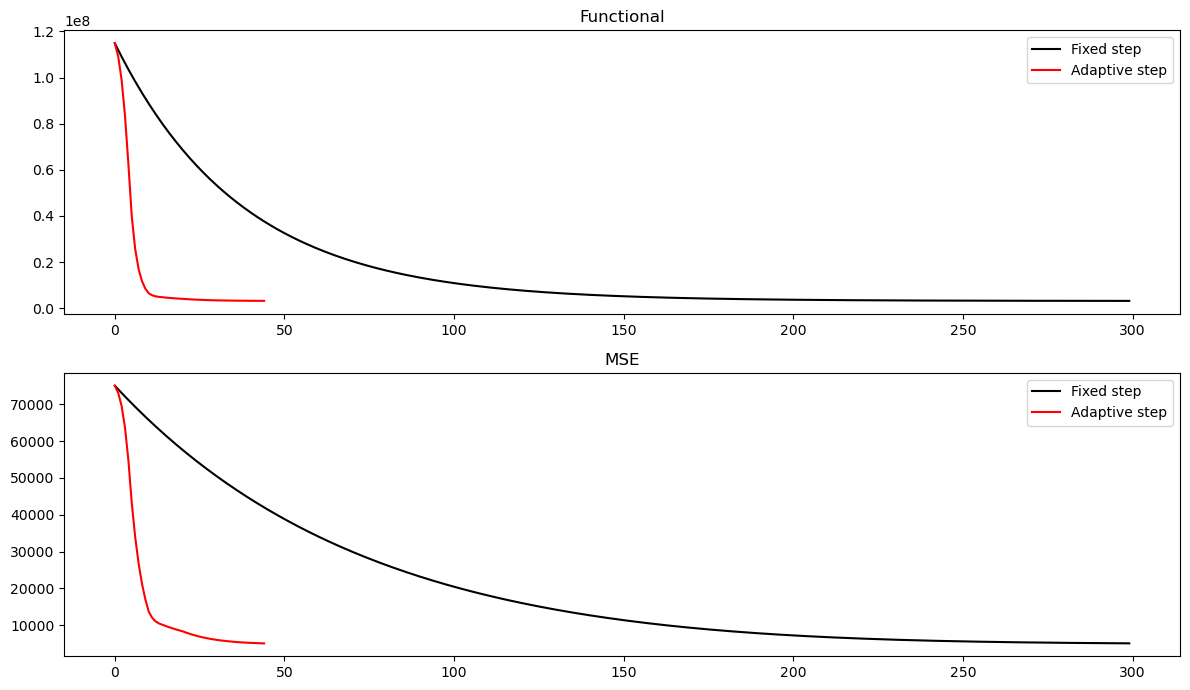

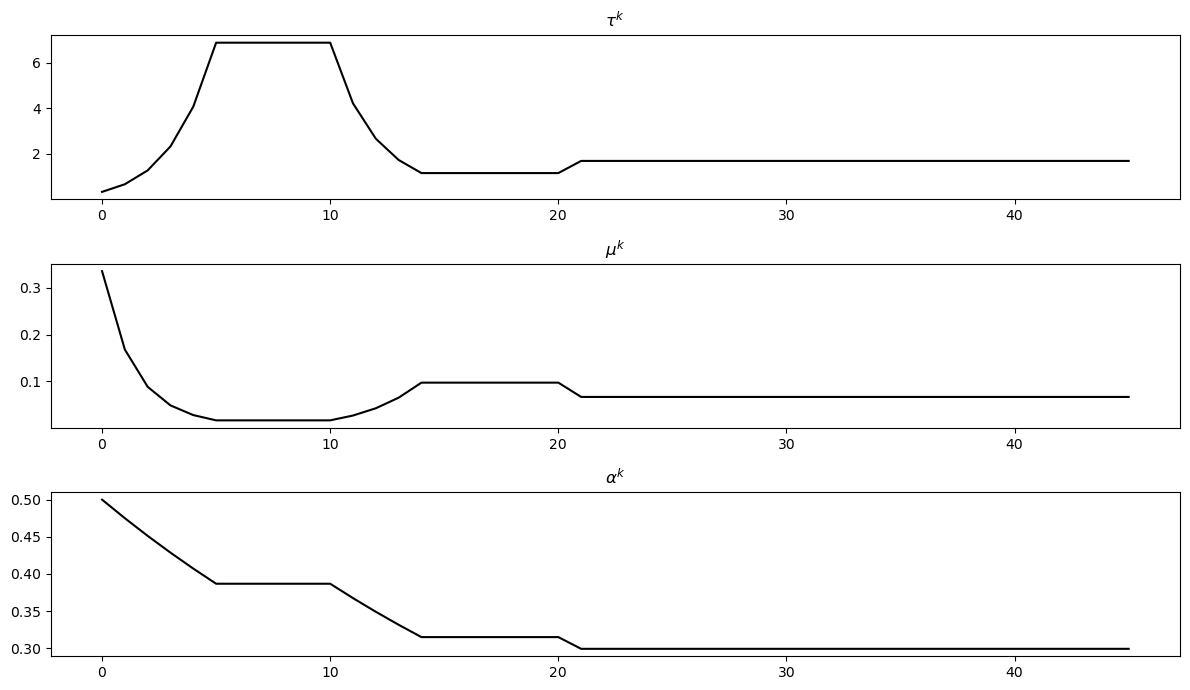

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].axis('tight')
axs[1].imshow(noise_img, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Noisy')
axs[1].axis('off')
axs[1].axis('tight')
axs[2].imshow(iml12_fixed, cmap='gray', vmin=0, vmax=255)
axs[2].set_title('PD')
axs[2].axis('off')
axs[2].axis('tight')
axs[3].imshow(iml12_ada, cmap='gray', vmin=0, vmax=255)
axs[3].set_title('Adaptive PD')
axs[3].axis('off')
axs[3].axis('tight')

fig, axs = plt.subplots(2, 1, figsize=(12, 7))
axs[0].plot(cost_fixed, 'k', label='Fixed step')
axs[0].plot(cost_ada, 'r', label='Adaptive step')
axs[0].legend()
axs[0].set_title('Functional')
axs[1].plot(err_fixed, 'k', label='Fixed step')
axs[1].plot(err_ada, 'r', label='Adaptive step')
axs[1].set_title('MSE')
axs[1].legend()
plt.tight_layout()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].plot(steps[0], 'k')
axs[0].set_title(r'$\tau^k$')
axs[1].plot(steps[1], 'k')
axs[1].set_title(r'$\mu^k$')
axs[2].plot(steps[2], 'k')
axs[2].set_title(r'$\alpha^k$')
plt.tight_layout();